# Numpy Tutorial
Joshua Stough, 202-

[Numpy](https://numpy.org/) is a powerful toolkit for the handling of large N-dimensional arrays or matrices, conveniently wrapped in Python. Given the relative inefficiencies of handling large lists of numbers in native Python, Numpy [`ndarray`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html)s have become the backbone of scientific computation in Python. In this notebook we'll first show some time comparisons between `ndarray` and Python list basic functions, then explore a some of the very useful Numpy methods. 

This is a highly stripped-down introduction. The intent is that much of what we need along the way, as we find uses for some of Numpy's functionality. See Numpy's own [quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html) for a more complete introduction.

1. [**Speed Comparisons**](#speedup)
1. [**Numpy Essentials**](#essentials)
  1. [Indexing operations](#essentials_indexops)
  1. [Multi-dimensional `ndarray`s](#essentials_multidim)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import dis
# Alternative to using the timeit magic command:
# from timeit import timeit

# And initialize the random number generator
np.random.seed(999)

<a id='speedup'></a>
## Speed Comparisons
We know Python lists as a really easy-to-use dynamic list implementation that includes powerful object-oriented and functional interactions, where elements of a list can be of any type. This flexibility of the list type is accomplished through the use of pointers in a way that is hidden from the programmer--under the hood. Numpy on the other hand constrains all elements of an `ndarray` to be of the same type; under the hood, numpy arrays can be stored in contiguous memory with constant access time. 

A tremendous speedup results from executing numpy's compiled library code on contiguous memory, versus Python's native implementations that require dealing with pointer indirection and the potential resulting scattered memory access. 

To demonstrate this, we'll make a Python list of random integers using numpy's [`randint`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html), a (uniformly distributed) random number generator. We'll also make a numpy `ndarray` copy of that list. This copy will be in memory that is independent of the list, which we are just copying the values from. 

Then we can test certain functionality on the `list` and `ndarray` collections separately, using IPython's [`timeit` magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit).. 

In [2]:
# Make a list of random integers in [0,10M)
lyst = [np.random.randint(0,10000000) for x in range(1000)]
np_lyst = np.array(lyst)

In [3]:
%%timeit
min(lyst)

10.3 µs ± 3.02 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


The expression we're timing is `min(lyst)`, which is the Python function to return the minimum of any iterable of comparable types in Python. The default output of `timeit` tells us with some degree of certainty how much wall time calculating `min(lyst)` is likely to take, probably in units of microseconds $\mu s$. `timeit` computes this by taking several runs (default 7) and each time executing the expression potentially thousands of times to get to some accuracy in the measurement.

In [4]:
%%timeit
np.min(np_lyst)

3.39 µs ± 22.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


You should notice a significant speedup in the `np.min()` result over the Python `min()` result. On my machine I observe ~3x speedup on a list of length 1000 (1K). In that there is always some baseline overhead cost due to the Python interpreter (as opposed to compiled library calls), you may notice that the speedup improves the larger the list size is made to be. I observed a ~12x speedup on a list size of 10K, and a 15-20x speedup beyond 100K. 

In [5]:
np_lyst.dtype

dtype('int64')

In [6]:
# Using getsizeof to ask Python the size in bytes of a Python variable.
sys.getsizeof(lyst[0])

28

In [7]:
type(lyst[0])

int

One significant note here is that there is a big precision reduction: the *integer* primitive in Python is for arbitrary magnitude integral values and requires 28 bytes, while the implicitly determined `np.int64` requires only 8 bytes with a more limited magnitude range. In conjunction with the direct packing (instead of pointer packing) in memory, the `ndarray` variable `np_lyst` requires much less memory than the Python variable `lyst`, and likely engenders much better cache coherence (read: average memory access time). Read more about it [here](https://webcourses.ucf.edu/courses/1249560/pages/python-lists-vs-numpy-arrays-what-is-the-difference) or [here](https://medium.com/@gough.cory/performance-of-numpy-array-vs-python-list-194c8e283b65). Additionally it is possible to write your own efficient C code implmentations that can be called from Python: read (much) more [here](https://medium.com/analytics-vidhya/beating-numpy-performance-by-extending-python-with-c-c9b644ee2ca8).

Computing the minimum of a collection is a straightforward linear complexity problem, $O(n)$. We'll now try another example, this time of sorting a `list/ndarray`, which you'll remember generally has complexity $O(n\log{}n)$.

In [8]:
%%timeit
sorted(lyst)

55.8 µs ± 33.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [9]:
%%timeit
np.sort(np_lyst)

14.5 µs ± 14.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Both the [`sorted()`](https://docs.python.org/3.7/howto/sorting.html) and [`np.sort()`](https://numpy.org/doc/stable/reference/generated/numpy.sort.html) methods are functions in the sense that they do not modify the argument collection (whether `list` or `ndarray`), but rather return a sorted copy of that collection. Alternative object-oriented in-place [`sort`](https://docs.python.org/3/library/stdtypes.html#list.sort) and [`ndarray.sort`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.sort.html#numpy.ndarray.sort) methods are also available. However, for the purposes of timing, sorting an already sorted list is pretty uninteresting. In the sorting experiment above, I observed ~2x speedup using the Numpy equivalent on list size 1K.

In [10]:
%%timeit
[4*x for x in lyst]

28 µs ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
%%timeit
list(map(lambda x: 4*x, lyst))

50.8 µs ± 56.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%%timeit
4*np_lyst

771 ns ± 2.86 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


The final timing examples above show the efficiency of Python list comprehensions and the equivalent numpy expression. The above list comprehensions (or `list(map(...`) create a new list object where every element of the original list has been scaled by a constant. Such Pythonic expressions execute in interpreted bytecode, which can be quite a bit slower than comparative compiled C. Using smart [operator overloading](https://docs.python.org/3/reference/datamodel.html#special-method-names), the creators of Numpy encoded equivalent functionality that executes almost entirely in C, resulting in significant speedup (e.g., ~70x on list size 10K in my observations). We can actually observe this efficiency indirectly just in the amount of bytecode involved in the competing approaches, using Python's [disassembler module](https://docs.python.org/3/library/dis.html).

In [13]:
dis.dis('[4*x for x in lyst]')

  1           0 LOAD_CONST               0 (<code object <listcomp> at 0x7efe09041270, file "<dis>", line 1>)
              2 LOAD_CONST               1 ('<listcomp>')
              4 MAKE_FUNCTION            0
              6 LOAD_NAME                0 (lyst)
              8 GET_ITER
             10 CALL_FUNCTION            1
             12 RETURN_VALUE

Disassembly of <code object <listcomp> at 0x7efe09041270, file "<dis>", line 1>:
  1           0 BUILD_LIST               0
              2 LOAD_FAST                0 (.0)
        >>    4 FOR_ITER                12 (to 18)
              6 STORE_FAST               1 (x)
              8 LOAD_CONST               0 (4)
             10 LOAD_FAST                1 (x)
             12 BINARY_MULTIPLY
             14 LIST_APPEND              2
             16 JUMP_ABSOLUTE            4
        >>   18 RETURN_VALUE


In [14]:
dis.dis('4*np_lyst')

  1           0 LOAD_CONST               0 (4)
              2 LOAD_NAME                0 (np_lyst)
              4 BINARY_MULTIPLY
              6 RETURN_VALUE


As an aside, `ndarray`s are static in that they cannot change size easily (without $O(n)$ cost). While this is a deficiency relative to Python's dynamic list implementation (with ammortized $O(1)$ cost to append), this is not much of a problem usually. 

Across computational workflows much more complicated than the above simple experiments demonstrate, people have found Numpy to be up to 100 times faster than native Python. To be clear, `ndarray`s cannot easily replace all Python lists in our lives: we are after all programming in Python! But in computationally intensive endeavors like image processing, where dealing with millions of pixels is an every second kind of thing, we will have to leverage Numpy's massive speedups.

<a id='essentials'></a>
## Numpy Essentials

As demonstrated above, Numpy often provides vastly superior performance for computationally intensive tasks on collections of data. Additionally, it also provides great new functionality that becomes quite useful in scientific computing contexts: index-related operations, dimension swapping, conditional filtering, etc.. In this section we'll explore some of this functionality. We'll also show similar Python list functionality in case that helps understanding. I'll often refer to the official [Numpy documentation](https://numpy.org/doc/stable/reference/index.html).

Let's start by making a small `ndarray` with random integer values for pedagogical purposes. All of the same examples could be easily extended to floating point or much larger arrays. 

In [15]:
# Some random integers in [5, 100). With named parameters for clarity.
np_lyst = np.random.randint(low=5,high=100,size=10)
lyst = list(np_lyst)

In [16]:
np_lyst

array([80, 69, 72, 69, 16, 11, 33, 83, 95, 30])

<a id='essentials_indexops'></a>
### Indexing Ops

We'll start with index-related operations. It is often advantageous to reorder collections (for example sorting) in a way that is reversible. To do this we need to record where each element came from. It's easy enough to get an index along with the associated element using [`enumerate`](https://docs.python.org/3/library/functions.html?highlight=enumerate#enumerate). 

Then, let's try finding the index of the minimum.

In [17]:
list(enumerate(np_lyst))

[(0, 80),
 (1, 69),
 (2, 72),
 (3, 69),
 (4, 16),
 (5, 11),
 (6, 33),
 (7, 83),
 (8, 95),
 (9, 30)]

In [18]:
# Equivalent, but kind of silly way to write it
# np.argmin(np_lyst)
np_lyst.argmin()

5

In [19]:
# List equivalent
# lyst.index(min(lyst)) # requires >= n ops, kind of silly

# Another approach, requiring exactly n-1 ops.
# mini = 0
# for (i,x) in enumerate(lyst[1:], start=1):
#     if x < lyst[mini]:
#         mini = i
# print(mini)

# A little obfuscated
mini = 0
for (i,x) in enumerate(lyst):
    mini = i if x < lyst[mini] else mini
print(mini)

5


As you can see, `ndarray`'s [`argmin`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.argmin.html) or equivalent [`numpy.argmin()`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html) methods can replace a bit of Python code. See also [`ndarray.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.argmax.html). Also note there are often equivalent functional `numpy` and object-oriented [`ndarray` methods](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html), as in `np.argmin(np_lyst)` and `np_lyst.argmin()` above.

We are often also interested in where some condition is true, as in 'is this element greater than 50' or 'is this part of an image sky.' We can use [`numpy.where()`](https://numpy.org/doc/stable/reference/generated/numpy.where.html) to get at that kind of information:

In [20]:
print(np_lyst)
print(np_lyst > 50)
np.where(np_lyst > 50)

[80 69 72 69 16 11 33 83 95 30]
[ True  True  True  True False False False  True  True False]


(array([0, 1, 2, 3, 7, 8]),)

In [21]:
# Pretty printed
print(' '.join([f'{x:>6d}' for x in np_lyst]))
print(' '.join([f'{str(x):>6s}' for x in np_lyst > 50]))
np.where(np_lyst > 50)

    80     69     72     69     16     11     33     83     95     30
  True   True   True   True  False  False  False   True   True  False


(array([0, 1, 2, 3, 7, 8]),)

In [22]:
# List equivalent
[i for i,x in enumerate(lyst) if x > 50]

[0, 1, 2, 3, 7, 8]

 In the above cell, I print out the elements of the `ndarray`, then the elements of a *conditional array* `np_lyst > 50`, then the output of the `where()` call. I also pretty-print the arrays for a little more clarity, which you can read a lot more about [here](https://realpython.com/python-formatted-output/). 
 
As you can see, when `where()` is sent an array, it will return an array of indices where non-zero (or non-`False`) elements can be found. You can actually see it's returning a tuple, which becomes relevant for multidimensional arrays--but we'll leave that for when it's actually relevant. A call to [`ndarray.nonzero`](https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html) on the conditional array itself is equivalent in this case:

In [23]:
(np_lyst > 50).nonzero()

(array([0, 1, 2, 3, 7, 8]),)

However `where` is quite a bit more powerful. We can use `where` to sample from two sources based on the condition argument. In the below, whenever the condition `> 50` is True in `np_lyst`, we sample the element directly, and otherwise the square root of the element is used. 

In [24]:
np.where(np_lyst>50, np_lyst, np.sqrt(np_lyst))

array([80.        , 69.        , 72.        , 69.        ,  4.        ,
        3.31662479,  5.74456265, 83.        , 95.        ,  5.47722558])

<a id='essentials_multidim'></a>
### Multi-dimensional `ndarray`s

Every [`ndarray`](https://numpy.org/devdocs/user/quickstart.html) object represents a multi-dimensional matrix of data. The hardest part about dealing with such large structured collections of data is always to keep in mind any particular `ndarray`s shape, dimensionality, and type of data, often along with the range of the data inside. Fortuitously, this is easily accessible in Numpy arrays through attributes and simple method calls. 

Let's start simple by instantiating a couple of 2D `ndarray`s.

In [25]:
a = np.random.randint(0,20, size=(4,6))
b = np.random.randint(20,40, size=(4,6))

In [26]:
a

array([[18, 11, 10,  8, 12,  1],
       [13, 12,  3, 18,  8, 15],
       [16, 18, 18, 19,  1,  7],
       [ 3,  5, 19, 12,  4,  3]])

In [27]:
b

array([[35, 39, 27, 33, 31, 30],
       [23, 24, 32, 22, 22, 31],
       [39, 38, 36, 34, 26, 35],
       [23, 31, 33, 30, 39, 24]])

You can see above that `a` and `b` are 4x6 matrices. In order to get at all of the details I mention above, let's make a reusable function  

In [28]:
# Given an ndarray, returns a tuple of info...
def arr_info(arr):
    return arr.shape, arr.dtype, arr.min(), arr.max()

In [29]:
arr_info(a)

((4, 6), dtype('int64'), 1, 19)

The `arr_info` function here accesses and returns the `arr` argument's `shape` and `dtype` attributes and calls on the `min` and `max` methods to give us a snapshot of the content. The dimensionality of `arr` is the length of the shape tuple returned (or also `a.ndim` would work). This `arr_info` function is so useful, we'll source it out to common utilities. 

In [30]:
c = a/b
print(c)
print(arr_info(c))

[[0.51428571 0.28205128 0.37037037 0.24242424 0.38709677 0.03333333]
 [0.56521739 0.5        0.09375    0.81818182 0.36363636 0.48387097]
 [0.41025641 0.47368421 0.5        0.55882353 0.03846154 0.2       ]
 [0.13043478 0.16129032 0.57575758 0.4        0.1025641  0.125     ]]
((4, 6), dtype('float64'), 0.03333333333333333, 0.8181818181818182)


There are a number of things to note about the above cell and its output:
- `a/b` means element-wise division. In fact all arithmetic ops between `ndarray` objects are [element-wise](https://numpy.org/devdocs/user/quickstart.html#basic-operations). 
- In order for element-wise to make sense, both operands (`a` and `b`) must be [*broadcastable*](https://numpy.org/devdocs/user/quickstart.html#broadcasting-rules) to the same shape. For example, `a/4` would work because `4` can be broadcast to 4x6 (copies of the number `4`).
- The result of `a/b` (and other such ops) is in fact a new `ndarray` object, which is then assigned the variable name `c`. 
- The result of integer division is floating point (see `dtype('float64')` above). 

We can slice and index an `ndarray` matrix in the same way we would a Python list of lists. Here, we'll make a 3x4 matrix and view some slices of it.

In [31]:
a = np.arange(12).reshape(3,4)
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [32]:
arr_info(a)

((3, 4), dtype('int64'), 0, 11)

In [33]:
# List equivalent gets sillier
rows = 3
columns = 4
alist = [[x+a*columns for x in range(columns)] for a in range(rows)]
print(alist)

[[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11]]


In [34]:
a[:2, 1:]

array([[1, 2, 3],
       [5, 6, 7]])

In [35]:
# List equivalent
[little_list[1:] for little_list in alist[:2]]

[[1, 2, 3], [5, 6, 7]]

In [36]:
a[:,:2]

array([[0, 1],
       [4, 5],
       [8, 9]])

In [37]:
a[...,:2]

array([[0, 1],
       [4, 5],
       [8, 9]])

In [38]:
# List equivalent
[little_list[:2] for little_list in alist]

[[0, 1], [4, 5], [8, 9]]

As seen above, we can slice an `ndarray` pretty easily (at least compared to the list equivalent). 
- As with Python slicing, `:k` means up to but not including index `k`, while `j:` means starting at index `j`. 
- `:` and `...` happen to mean the same in the above cells only because `a` is 2D. For a matrix of higher dimensionality, `a[...,:2]` would mean `a[:,:,:2]` or `a[:,:,:,:2]` or so on. That is, for all dimensions iterate over all elements.

Let's up the dimensionality to 3. We'll `reshape` the 12 elements of `a` to be 2x2x3 instead of 3x4.

In [39]:
a = a.reshape(2,2,3)
a

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [40]:
a[...,0]

array([[0, 3],
       [6, 9]])

In [41]:
a[1,1,:]

array([ 9, 10, 11])

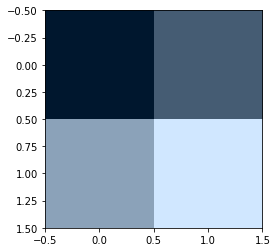

In [42]:
plt.figure()
plt.imshow(a/11)

The reshaping we did here could for example represent a 2 pixel by 2 pixel image with 3 'color channels.' If the three color channels represent the amount of red, green, and blue, then each pixel would have a bluish hue since blue > green > red in the last or 'color' dimension. But here we're getting ahead of ourselves. 

We can also [transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html) dimensions or [flip](https://numpy.org/doc/stable/reference/generated/numpy.flip.html) the order of elements within one dimension.

In [43]:
# Again, a is 2x2x3
a

array([[[ 0,  1,  2],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [44]:
a.transpose(2,0,1)

array([[[ 0,  3],
        [ 6,  9]],

       [[ 1,  4],
        [ 7, 10]],

       [[ 2,  5],
        [ 8, 11]]])

In [45]:
print(arr_info(a))
print(arr_info(a.transpose(2,0,1)))

((2, 2, 3), dtype('int64'), 0, 11)
((3, 2, 2), dtype('int64'), 0, 11)


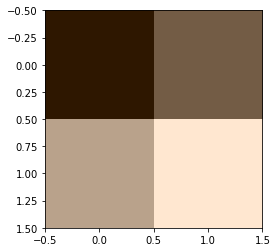

In [47]:
plt.figure()
plt.imshow(np.flip(a/11, axis=2))

When we `np.flip()` axis 2 (the last of the 2x2x3 matrix) of `a`, we make red > green > blue. As a result each pixel has a beige hue. But again, we're getting ahead of ourselves...

This has been a very brief introduction to some Numpy and `ndarray` functionality and interaction. We will pick up more as we need it. As in the [malaphor](https://docforce.io/malaphors-well-burn-that-bridge-when-we-get-to-it/), "We'll burn that bridge when we get to it." Again, see Numpy's own [quickstart tutorial](https://numpy.org/devdocs/user/quickstart.html) for a more complete and abstract introduction.